## Import and configure Sentinel Hub API with credentials

In [10]:
# import config for Sentinel Hub API
from sentinelhub import SHConfig
# import personal config settings – keep them secret!
import sentinelconfig

config = SHConfig()
config.instance_id = sentinelconfig.instance
config.sh_client_id = sentinelconfig.client_ID
config.sh_client_secret = sentinelconfig.instance

# save current config settings
config.save()

# prompt warning if no credentials
if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")


In [11]:
# import modules for retrieving and plotting
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np


# specific syntax for Sentinel Hub API
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image


In [12]:
# WGS84 coords for Area Of Interest (AOI) 
# First the long. and lat. for the bottom left corner, then long. lat. top right corner
# Beware if you get coords from maps it's inverted!
atacama_coords_wgs84 = [-70.57, -23.95, -70.11, -23.51]

# Resolution, possible params 20, 40, 60 – the lower the par the highest the resolution
resolution = 20
# Create a bbox for your area, using coords and crs
atacama_bbox = BBox(bbox=atacama_coords_wgs84, crs=CRS.WGS84)
# Converts the resolution param into meters and provide the correct image
atacama_size = bbox_to_dimensions(atacama_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {atacama_size} pixels")


Image shape at 20 m resolution: (2322, 2458) pixels


## True color of specific date
Full example at: https://sentinelhub-py.readthedocs.io/en/latest/examples/process_request.html 

In [13]:
# Evaluation script to select the correct bands and merge them into  true color
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=("2020-12-12", "2020-12-12"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=atacama_bbox,
    size=atacama_size,
    config=config,
)


In [14]:
true_color_imgs = request_true_color.get_data()


In [15]:
print(
    f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}.")
print(
    f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}")


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (2458, 2322, 3)


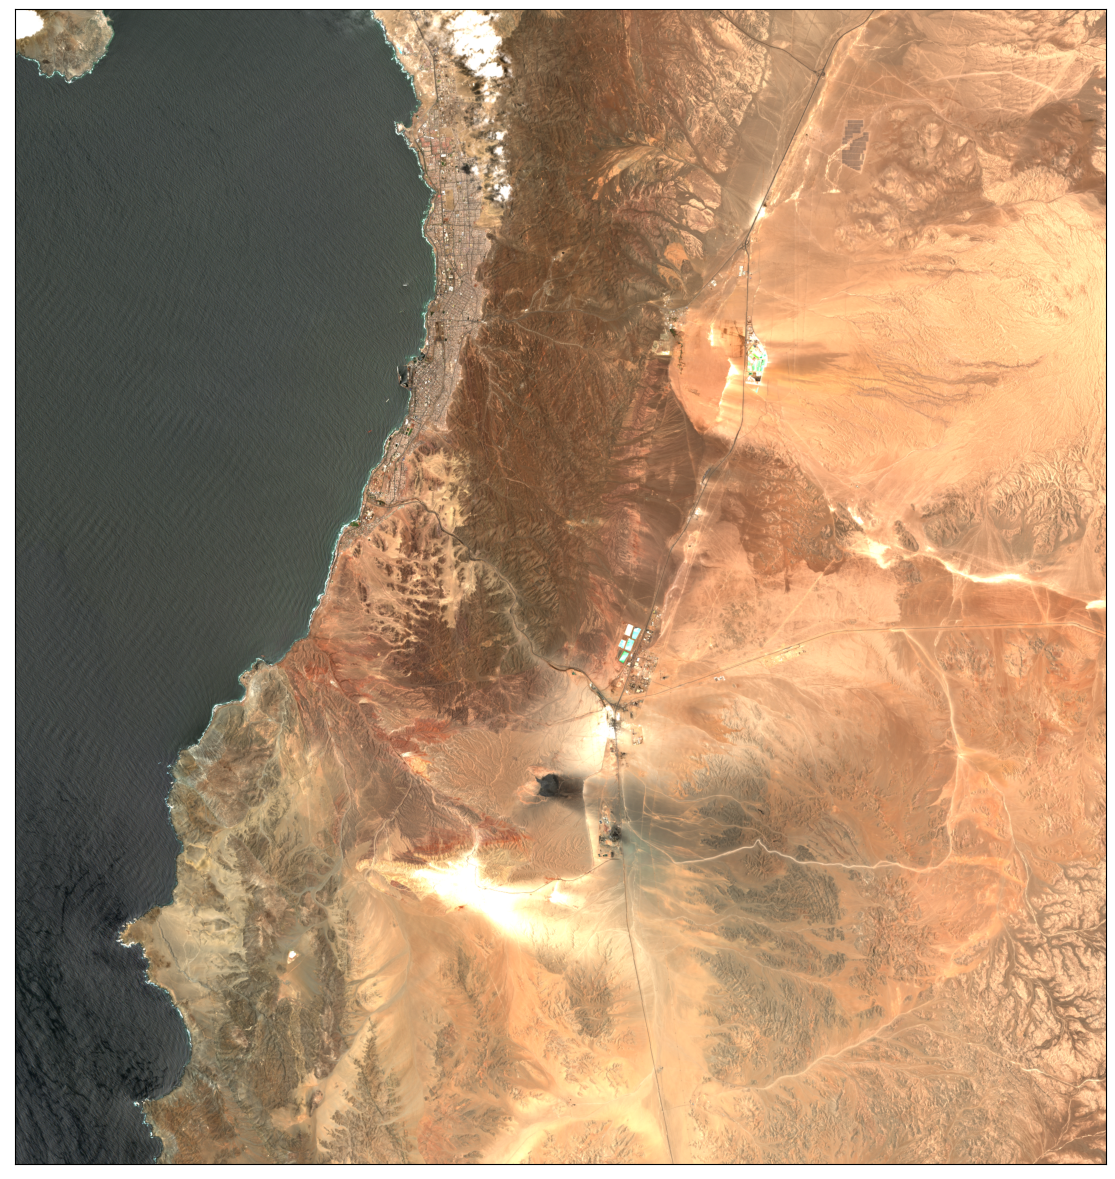

In [16]:
plot_image(request_true_color.get_data()[
           0], factor=3.5 / 255, clip_range=(0, 1))
